In [195]:
%matplotlib inline
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split, KFold
import matplotlib.pyplot as plt
import re
import seaborn as sns

In [196]:
#Load and inspect data
df = pd.read_csv('Tweets.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
tweet_id                        14640 non-null int64
airline_sentiment               14640 non-null object
airline_sentiment_confidence    14640 non-null float64
negativereason                  9178 non-null object
negativereason_confidence       10522 non-null float64
airline                         14640 non-null object
airline_sentiment_gold          40 non-null object
name                            14640 non-null object
negativereason_gold             32 non-null object
retweet_count                   14640 non-null int64
text                            14640 non-null object
tweet_coord                     1019 non-null object
tweet_created                   14640 non-null object
tweet_location                  9907 non-null object
user_timezone                   9820 non-null object
dtypes: float64(2), int64(2), object(11)
memory usage: 1.7+ MB


In [161]:
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [197]:
def clean_df(df):
    df = df.loc[: , ['airline_sentiment', 
                         'airline_sentiment_confidence',
                         'negativereason',
                         'negativereason_confidence',              
                         'name',
                         'text',
                         'tweet_coord',
                         'tweet_created',
                         'airline']].rename(columns = {'airline_sentiment':'Rating',
                                                             'airline_sentiment_confidence':'Rating_Conf',
                                                             'negativereason':'Negative_Reason',
                                                             'negativereason_confidence':'Reason_Conf',
                                                             'name':'User',
                                                             'text':'Text',
                                                             'tweet_coord':'Coordinates',
                                                             'tweet_created':'Date'}).set_index('Date')
    return df

clean_df(df).head(10)


,Rating,Rating_Conf,Negative_Reason,Reason_Conf,User,Text,Coordinates,airline
Date,,,,,,,,
2015-02-24 11:35:52 -0800,neutral,1.0000,NaN,NaN,cairdin,@VirginAmerica What @dhepburn said.,NaN,Virgin America
2015-02-24 11:15:59 -0800,positive,0.3486,NaN,0.0000,jnardino,@VirginAmerica plus you've added commercials t...,NaN,Virgin America
2015-02-24 11:15:48 -0800,neutral,0.6837,NaN,NaN,yvonnalynn,@VirginAmerica I didn't today... Must mean I n...,NaN,Virgin America
2015-02-24 11:15:36 -0800,negative,1.0000,Bad Flight,0.7033,jnardino,@VirginAmerica it's really aggressive to blast...,NaN,Virgin America
2015-02-24 11:14:45 -0800,negative,1.0000,Can't Tell,1.0000,jnardino,@VirginAmerica and it's a really big bad thing...,NaN,Virgin America
2015-02-24 11:14:33 -0800,negative,1.0000,Can't Tell,0.6842,jnardino,@VirginAmerica seriously would pay $30 a fligh...,NaN,Virgin America
2015-02-24 11:13:57 -0800,positive,0.6745,NaN,0.0000,cjmcginnis,"@VirginAmerica yes, nearly every time I fly VX...",NaN,Virgin America
2015-02-24 11:12:29 -0800,neutral,0.6340,NaN,NaN,pilot,@VirginAmerica Really missed a prime opportuni...,NaN,Virgin America
2015-02-24 11:11:19 -0800,positive,0.6559,NaN,NaN,dhepburn,"@virginamerica Well, I didn't…but NOW I DO! :-D",NaN,Virgin America


In [198]:
df.replace({'airline_sentiment': {'positive': 1, 'negative': 0, 'neutral': 1}})

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,1,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,1,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,1,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,0,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,0,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
5,570300767074181121,0,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada)
6,570300616901320704,1,0.6745,NaN,0.0000,Virgin America,NaN,cjmcginnis,NaN,0,"@VirginAmerica yes, nearly every time I fly VX...",NaN,2015-02-24 11:13:57 -0800,San Francisco CA,Pacific Time (US & Canada)
7,570300248553349120,1,0.6340,NaN,NaN,Virgin America,NaN,pilot,NaN,0,@VirginAmerica Really missed a prime opportuni...,NaN,2015-02-24 11:12:29 -0800,Los Angeles,Pacific Time (US & Canada)
8,570299953286942721,1,0.6559,NaN,NaN,Virgin America,NaN,dhepburn,NaN,0,"@virginamerica Well, I didn't…but NOW I DO! :-D",NaN,2015-02-24 11:11:19 -0800,San Diego,Pacific Time (US & Canada)
9,570295459631263746,1,1.0000,NaN,NaN,Virgin America,NaN,YupitsTate,NaN,0,"@VirginAmerica it was amazing, and arrived an ...",NaN,2015-02-24 10:53:27 -0800,Los Angeles,Eastern Time (US & Canada)


In [199]:
#Groupby airline, and reference the ratings column and then extract total count
print(clean_df(df).groupby('airline')['Rating'].count())

airline
American          2759
Delta             2222
Southwest         2420
US Airways        2913
United            3822
Virgin America     504
Name: Rating, dtype: int64


In [200]:
#groupby both airlines and rating and extract total count

print(clean_df(df).groupby(['airline','Rating']).count().iloc[:,0])

airline         Rating  
American        negative    1960
                neutral      463
                positive     336
Delta           negative     955
                neutral      723
                positive     544
Southwest       negative    1186
                neutral      664
                positive     570
US Airways      negative    2263
                neutral      381
                positive     269
United          negative    2633
                neutral      697
                positive     492
Virgin America  negative     181
                neutral      171
                positive     152
Name: Rating_Conf, dtype: int64


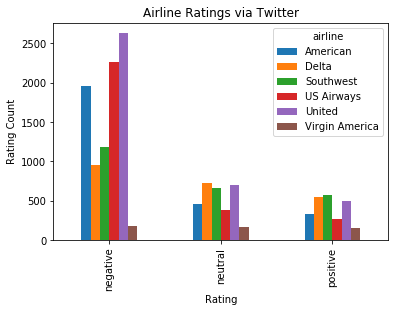

In [201]:
#create a graph by calling our clean_data function and then plots the total number of each tweet rating (positive,negative, or neutral)
ax = clean_df(df).groupby(['airline','Rating']).count().iloc[:,0].unstack(0).plot(kind = 'bar', title = 'Airline Ratings via Twitter')
ax.set_xlabel('Rating')
ax.set_ylabel('Rating Count')


plt.show()

In [202]:
#data_PWP_Path = ("positivewords.txt")
#positive_keywords = pd.read_csv(data_PWP_Path, delimiter= '\t')
#positive_keywords = positive_keywords["KEYWORDS"].tolist()


In [203]:
positive_keywords = ['ok','increase','better','thumbs','price','very',
            'significantly','strong','perfectly','surprised','amazed','sturdy','securely','right',
            'joy','finally','satisfied','better','super','well','nice', 'clear','finished','well','more',
            'pretty','easy','easier','fulfills','ideal','beautiful','best','works','comfortable',
            'ideal','recommend','good','happy','like', 'excellent', 'awesome','cool',
            'fantastic','love','reasonable','fine','great','impressed','wanted','important',
            'sturdiness','encourage','happier','comfort','excited','flawlessly','pleased','outperform','stars','adorable']


for keyPosStr in positive_keywords:
    df[str(keyPosStr)] = df.text.str.contains(' '+str(keyPosStr)+' ',case=False)

In [204]:
df.replace({'airline_sentiment': {'positive': 1, 'negative': 0, 'neutral': 1}})
df

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,...,sturdiness,encourage,happier,comfort,excited,flawlessly,pleased,outperform,stars,adorable
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,...,False,False,False,False,False,False,False,False,False,False
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,...,False,False,False,False,False,False,False,False,False,False
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,...,False,False,False,False,False,False,False,False,False,False
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,...,False,False,False,False,False,False,False,False,False,False
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,...,False,False,False,False,False,False,False,False,False,False
5,570300767074181121,negative,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,...,False,False,False,False,False,False,False,False,False,False
6,570300616901320704,positive,0.6745,NaN,0.0000,Virgin America,NaN,cjmcginnis,NaN,0,...,False,False,False,False,False,False,False,False,False,False
7,570300248553349120,neutral,0.6340,NaN,NaN,Virgin America,NaN,pilot,NaN,0,...,False,False,False,False,False,False,False,False,False,False
8,570299953286942721,positive,0.6559,NaN,NaN,Virgin America,NaN,dhepburn,NaN,0,...,False,False,False,False,False,False,False,False,False,False
9,570295459631263746,positive,1.0000,NaN,NaN,Virgin America,NaN,YupitsTate,NaN,0,...,False,False,False,False,False,False,False,False,False,False


In [205]:
clean_df(df)['allText'] = df.text.str.isupper()
clean_df(df)

,Rating,Rating_Conf,Negative_Reason,Reason_Conf,User,Text,Coordinates,airline
Date,,,,,,,,
2015-02-24 11:35:52 -0800,neutral,1.0000,NaN,NaN,cairdin,@VirginAmerica What @dhepburn said.,NaN,Virgin America
2015-02-24 11:15:59 -0800,positive,0.3486,NaN,0.0000,jnardino,@VirginAmerica plus you've added commercials t...,NaN,Virgin America
2015-02-24 11:15:48 -0800,neutral,0.6837,NaN,NaN,yvonnalynn,@VirginAmerica I didn't today... Must mean I n...,NaN,Virgin America
2015-02-24 11:15:36 -0800,negative,1.0000,Bad Flight,0.7033,jnardino,@VirginAmerica it's really aggressive to blast...,NaN,Virgin America
2015-02-24 11:14:45 -0800,negative,1.0000,Can't Tell,1.0000,jnardino,@VirginAmerica and it's a really big bad thing...,NaN,Virgin America
2015-02-24 11:14:33 -0800,negative,1.0000,Can't Tell,0.6842,jnardino,@VirginAmerica seriously would pay $30 a fligh...,NaN,Virgin America
2015-02-24 11:13:57 -0800,positive,0.6745,NaN,0.0000,cjmcginnis,"@VirginAmerica yes, nearly every time I fly VX...",NaN,Virgin America
2015-02-24 11:12:29 -0800,neutral,0.6340,NaN,NaN,pilot,@VirginAmerica Really missed a prime opportuni...,NaN,Virgin America
2015-02-24 11:11:19 -0800,positive,0.6559,NaN,NaN,dhepburn,"@virginamerica Well, I didn't…but NOW I DO! :-D",NaN,Virgin America


In [206]:
#Split into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [207]:
nb = BernoulliNB()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[3029,   13,   43],
       [ 966,    6,   12],
       [ 629,    7,  127]], dtype=int64)

In [208]:
#Predictive accuracy
kf = KFold(10)
scores = cross_val_score(nb, X_test, y_test, cv=kf)
print('Cross-validated scores:', scores)
print('Cross-validation average:', scores.mean())


Cross-validated scores: [0.6446281  0.64256198 0.66252588 0.67494824 0.68115942 0.67080745
 0.63354037 0.64596273 0.65010352 0.65217391]
Cross-validation average: 0.6558411614735726


# NLP Sentiment 

In [209]:

import nltk
import string
from nltk.corpus import stopwords
nltk.download('stopwords')
def pre_process(text):
    clean_text=[char for char in text if char not in string.punctuation]
    clean_text="".join(clean_text)
    clean_text=[words for words in clean_text.split() if words not in stopwords.words('english')]
    return clean_text


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\alpgulden\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [210]:
from sklearn.feature_extraction.text import CountVectorizer
x = CountVectorizer(analyzer=pre_process).fit(df['text'])
x = x.transform(df['text'])
y=df['airline_sentiment']

In [211]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=101)

In [212]:
from sklearn.naive_bayes import MultinomialNB
nb=MultinomialNB()
nb.fit(x_train,y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [213]:
pred=nb.predict(x_test)
y_pred_prob = nb.predict_proba(x_test)[:,1]
print("%"+str(accuracy_score(y_test,pred)))
print(confusion_matrix(y_test, pred))

%0.7502276867030966
[[2599   91   48]
 [ 528  346   73]
 [ 304   53  350]]


In [215]:
from sklearn.metrics import classification_report
print(classification_report(y_test, pred,target_names=['Positive',' Negative','Neutral']))

             precision    recall  f1-score   support

   Positive       0.76      0.95      0.84      2738
   Negative       0.71      0.37      0.48       947
    Neutral       0.74      0.50      0.59       707

avg / total       0.74      0.75      0.72      4392



In [218]:
df2 = pd.DataFrame({'Actual': y_test,'Predict': pred, 'Predict_Prob': (y_pred_prob*100)})  
df2.head(15)

,Actual,Predict,Predict_Prob
4814,positive,positive,8.657194e-02
150,negative,negative,2.931036e+00
5322,neutral,negative,7.161695e+00
4885,positive,negative,3.049519e+00
7504,negative,negative,4.244034e-05
12783,negative,negative,3.361444e-04
6912,negative,negative,7.056537e-03
2991,negative,negative,9.687969e-07
741,negative,negative,8.874467e-03
9526,negative,negative,9.912558e-04


In [220]:
def predictSentiment(strSentence):
    x = CountVectorizer(analyzer=pre_process).fit(df['text'])
    strSentence=x.transform([strSentence])
    print(nb.predict(strSentence)[0])
    

In [221]:
predictSentiment("Great value.")
predictSentiment("Don't fly with this airline")

positive
negative
